# Tensors and Neural Networks

This tutorial is an introduction to the concept of tensors and neural networks as were implemented in `rapaio-lib.7.0.1`. It is not a comprehensive detailed presentation, but it should be enough to give you a glimpse about how neural networks works in this library. If you have knowledge about Pytorch, many concepts should be similar since many ideas were used as a source of inspiration.

In [1]:
%load ../../rapaio-bootstrap.ipynb

Adding dependency io.github.padreati:rapaio-lib:7.0.1
Solving dependencies
Resolved artifacts count: 1
Add to classpath: /home/ati/work/rapaio-jupyter-kernel/target/mima_cache/io/github/padreati/rapaio-lib/7.0.1/rapaio-lib-7.0.1.jar


## What is a Tensor

A tensor is an object which handles multidimensional array values and has gradients attached to them. Both tensor values and gradients are darrays (multidimensional arrays implemented by `DArray<? extends Number>`). This is different from other similar tensor libraries like Pytorch, where tensor objects are multidimensional arrays. 

This is a design decision aimed to separate tensor logic (connected with computatinal nodes, gradients, autodifferentiation, and in the end with neural networks) from linear algebra implementation (which resides in darrays). The benefit of this separation is that instead of working with one big problem, we work with two separate smaller problems. 

Thus, the two main properties of a tensor are its value and its gradient. If the tensor is not created from scratch (like variables), its values its computed at the creation time. For tensor variables their value can be assigned later, but it must be available before the tensor is used in any operation. Building tensors and performing operations with them (which produces also tensors) creates a computational graph. In this computational graph tensor variables are leaves, and tensors created as a result of an operation creates intermediate nodes. During operations no gradient is created. 

Tensors are used mostly in neural networks, but they can be used for other purposes, also. There is not any dependence of tensors to neural networks (the reverse is not true). In neural networks there are usual two main processes: inference and training. During inference no gradient is computed, only the tensor values are created in the computational graph. Training a neural network performs the inference part, but later it uses the errors to backpropagate them to tensors in the form of gradients. Later, those gradients are used to update network parameters to adjust their values. 

`rapaio-lib-7.0.1` implements an algorithm for autodifferentiation in reverse mode. This is contained in the class `Autograd`. There are many tutorial explaining what autodifferentiation in reverse mode is, this tutorial will not contain those details. We will describe brefly the process and other separate pages needs to be created to present them in detail. 

### TensorManager

A `TensorManager` is responsible for handling internal computation and tracking details when someone is working with tensors. It also the object responsible with the creation tensor variable. A tensor manager needs to be created before starting to work with tensors. Tensor manager implements `AutoClosable`, thus a good practice would be to close the tensor manager after we finished the work with it. Use a `try` block or close it explicitly. 

The current implementation does not deallocate tensors and their underlying darrays, but in the future it is very possible if implementations of darrays will be provided which would work with foreign memory. A tensor manager instance should work like a context manager in python, but since Java does not provide such language facility, we need to pass the instance of tensor manager to most of the involved objects. Also, a tensor manager has a default type. This type is the data type used to create intermediate tensors and affects also computation. Thus, if one wants to switch between double and float, the easiest way would be to create a tensor manager instance with appropriate type and the rest of the code could remain the same. 

In [2]:
TensorManager tm = TensorManager.ofFloat();
tm.seed(42);

The previous lines of code creates a tensor manager with float as default value type and fixes a seed for randomization. If no parallelism is used, the randomization should produce reproducible results.

## Tensors and computational graphs

One can simply create tensor variables using the available methods from tensor manager.

In [33]:
var x = tm.var().name("x").requiresGrad(true);
print(x);

name:(x)
val:
grad:null

We created a new tensor variable with no value, the gradient is null since it is not computed and its name is `x`. We can assign a value to the tensor. This can also be done at creation time. Notice that we explicitly requested the gradient computation. By default any avriable does not request to compute any gradient. If you want to change that, this must be requeste explicitly.

In [34]:
x.setValue(tm.randomArray(Shape.of(3,4), tm.random()));
print(x)

name:(x)
val:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 0.5165038704872131  1.332271933555603   -0.8554643392562866    0.8746757507324219  ]  
 [ 0.3263845145702362 -0.09187350422143936 -0.5084207653999329    0.10020556300878525 ]  
 [ 0.3454208970069885 -1.1442604064941406  -0.006700537167489529 -1.9218206405639648  ]] 
grad:null

Notice that now the tensor has a value, the gradient still missing. Let's compute some other things.

In [35]:
var sqr = x.sqr();
print(sqr);

name:(Sqr)
val:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 0.2667762339115143  1.7749484777450562   0.731819212436676      0.7650576829910278  ]  
 [ 0.10652685165405273 0.008440740406513214 0.2584916651248932     0.01004115492105484 ]  
 [ 0.11931559443473816 1.3093318939208984   0.00004489719867706299 3.693394660949707   ]] 
grad:null

In [36]:
var sum = sqr.sum();
print(sum);

name:(Sum)
val:BaseStride{FLOAT,[],0,[]}
 9.044189453125  
grad:null

Notice that the sum is a scalar, since we called a reduce operation on the whole range. If we have a scalar node as a result of the computation, we can set its gradient to `1`, and we can call autodiff engine to compute derivatives. 

**Note:** it is important to call autodiff engine on a tensor with a scalar values. This is needed in order to be able to compute gradients.

In [37]:
sum.setGrad(tm.scalarArray(1));
print(sum);

name:(Sum)
val:BaseStride{FLOAT,[],0,[]}
 9.044189453125  
grad:BaseStride{FLOAT,[],0,[]}
 1  


In [38]:
var cgraph = Autograd.backward(sum);

The previous line of code calls the autodifferentiation engine which will trace back the tensors which needs to have a computed gradient and performs gradient computations. We can see now the gradients of our created tensors.

In [39]:
print(x, sqr, sum);

name:(x)
val:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 0.5165038704872131  1.332271933555603   -0.8554643392562866    0.8746757507324219  ]  
 [ 0.3263845145702362 -0.09187350422143936 -0.5084207653999329    0.10020556300878525 ]  
 [ 0.3454208970069885 -1.1442604064941406  -0.006700537167489529 -1.9218206405639648  ]] 
grad:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 1.0330077409744263  2.664543867111206   -1.7109286785125732    1.7493515014648438 ]  
 [ 0.6527690291404724 -0.18374700844287872 -1.0168415307998657    0.2004111260175705 ]  
 [ 0.690841794013977  -2.2885208129882812  -0.013401074334979057 -3.8436412811279297 ]] 
name:(Sqr)
val:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 0.2667762339115143  1.7749484777450562   0.731819212436676      0.7650576829910278  ]  
 [ 0.10652685165405273 0.008440740406513214 0.2584916651248932     0.01004115492105484 ]  
 [ 0.11931559443473816 1.3093318939208984   0.00004489719867706299 3.693394660949707   ]] 
grad:BaseStride{FLOAT,[3, 4],0,[0, 0]}
[[ 1 1 1 1 ]  
 

We displayed manually the objects from the computed graph. This is not needed since we can use the result of `Autograd.backward` call which is an object which helps us to navigate through what happened behind the scenes. One useful method is to print all the tensors involved in gradient computing.

In [41]:
cgraph.printTensors()

name:(Sum)
val:BaseStride{FLOAT,[],0,[]}
 9.044189453125  
grad:BaseStride{FLOAT,[],0,[]}
 1  

name:(Sqr)
val:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 0.2667762339115143  1.7749484777450562   0.731819212436676      0.7650576829910278  ]  
 [ 0.10652685165405273 0.008440740406513214 0.2584916651248932     0.01004115492105484 ]  
 [ 0.11931559443473816 1.3093318939208984   0.00004489719867706299 3.693394660949707   ]] 
grad:BaseStride{FLOAT,[3, 4],0,[0, 0]}
[[ 1 1 1 1 ]  
 [ 1 1 1 1 ]  
 [ 1 1 1 1 ]] 

name:(x)
val:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 0.5165038704872131  1.332271933555603   -0.8554643392562866    0.8746757507324219  ]  
 [ 0.3263845145702362 -0.09187350422143936 -0.5084207653999329    0.10020556300878525 ]  
 [ 0.3454208970069885 -1.1442604064941406  -0.006700537167489529 -1.9218206405639648  ]] 
grad:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 1.0330077409744263  2.664543867111206   -1.7109286785125732    1.7493515014648438 ]  
 [ 0.6527690291404724 -0.18374700844287872 -1.016841

Another useful method available in the computing graph helper is `resetGrad` which sets to null all the gradients of the involved variables. This is useful if we want to clean up the mess. After calling this method we can see no other tensor have gradients.

In [46]:
cgraph.resetGrad();
cgraph.printTensors();

name:(Sum)
val:BaseStride{FLOAT,[],0,[]}
 9.044189453125  
grad:null
name:(Sqr)
val:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 0.2667762339115143  1.7749484777450562   0.731819212436676      0.7650576829910278  ]  
 [ 0.10652685165405273 0.008440740406513214 0.2584916651248932     0.01004115492105484 ]  
 [ 0.11931559443473816 1.3093318939208984   0.00004489719867706299 3.693394660949707   ]] 
grad:null
name:(x)
val:BaseStride{FLOAT,[3, 4],0,[4, 1]}
[[ 0.5165038704872131  1.332271933555603   -0.8554643392562866    0.8746757507324219  ]  
 [ 0.3263845145702362 -0.09187350422143936 -0.5084207653999329    0.10020556300878525 ]  
 [ 0.3454208970069885 -1.1442604064941406  -0.006700537167489529 -1.9218206405639648  ]] 
grad:null


## Anatomy of training a neural network

For those familiar with Pytorch, the components involved in training a neural network are very similar. Anyway, we will try to presents all the components briefly and explain what they do and why they are needed.

So we want to train a neural network. How to start?

### Network

The first step would be to create a neural network in the first place. We need to have something to train. The details and some examples will be provided below, but for now we can consider that somehow we create a network. A network in an object which implements `Network`. This is our model. We use this model to do inferences and we use this model to improve it using training.

Another critical ingredient is data, precisely labeled data. In most cases learning in machine learning means extracting knowledge from past experiences and use that knowledge to do predictions for new situations. Labeled data represents that knowledge quantified in numbers (most of the time). This labeled data should come in the form of ... tensors (yeah, it was not hard to guess it). 

### TabularDataset

When we train a network, we can use directly tensors as inputs, or we can use some helper classes to make this process easier. One of those classes is `TabularDataset`. A `TabulatDataset` helps us to manage labeled data, to create iterator in that data or batch iterators. As it was said, using a dataset helper is not critical, but can simplify our training process.

### Loss function

The process of training a neural network implies passing labeled data to the model to compute predictions, we compare those predictions with the expected values (the labels) and compute an error in some form. We may choose how to measure errors and what, actually, errors are. We do that using a loss function. A `Loss` function is a function which computes an error given some predictions and some expected values, and it has an analytical form.

### Autograd 

We take this error information and pass it back in a recursive fashion in the network, so it propagates. This is called backpropagation. After the backpropagated errors are cristalized in form of gradients. One per each intersting tensor from the network. The component which does this is called `Autograd`. 

### Optimizer

After those gradients are computed we use a strategy to transfer information from gradients to their corresponding tensor values. This is the output of the learning, changing the parameter values from a network as a result of measuring errors in the hope that the model now adjusted will predict better in the future. The strategy to transfer information from gradients to its tensor values is called optimization. In rapaio this is a object which implements an `Optimizer`.



These are the required ingredients to train a neural network. For those who have seen similar, much better and famous libraries, those components should look familiar to you.

Additionally, to describe the main components of training, we should say that when the whole training data is passed to the model we name that an *epoch*. For various reasons we do not pass all the training data at once, but in small slices. We name those slices *batches* or *mini-batches*. There could be multiple reasons for that, but two of them are often encoutered: the training data simply does not fit the available resources (memory, disk) or training in batches produces better results. After an epoch pass we do it again, and again, until we are content with the results. Rinse and repeat.

We can be content if we measure properly how model performs. For this purpose many strategies can be emplyed, but a fundamental one is to split data in training, validation, and test, or simply in training and test. For that purpose tabular dataset helper can make your life easier.

## Hands on example: Iris classifier

For illustration forposes we will train a neural network to classify Iris data set. Iris dataset a as simple as possible, and this was chosen on purpose, since I want you to focus on how training a network happens. It is like a "Hello world" program for classification.

First we need to get a dataset. The iris dataset is already incorporated in the library and we can load it.

In [59]:
TensorManager tm = TensorManager.ofFloat();
Frame iris = Datasets.loadIrisDataset();
iris.printSummary();

Frame Summary
* rowCount: 150
* complete: 150/150
* varCount: 5
* varNames: 

0. sepal-length : dbl | 3.  petal-width : dbl | 
1.  sepal-width : dbl | 4.        class : nom | 
2. petal-length : dbl | 

* summary: 
 sepal-length [dbl]      sepal-width [dbl]      petal-length [dbl]      petal-width [dbl]     
       Min. : 4.3000000       Min. : 2.0000000        Min. : 1.0000000       Min. : 0.1000000 
    1st Qu. : 5.1000000    1st Qu. : 2.8000000     1st Qu. : 1.6000000    1st Qu. : 0.3000000 
     Median : 5.8000000     Median : 3.0000000      Median : 4.3500000     Median : 1.3000000 
       Mean : 5.8433333       Mean : 3.0573333        Mean : 3.7580000       Mean : 1.1993333 
    2nd Qu. : 6.4000000    2nd Qu. : 3.3000000     2nd Qu. : 5.1000000    2nd Qu. : 1.8000000 
       Max. : 7.9000000       Max. : 4.4000000        Max. : 6.9000000       Max. : 2.5000000 
                                                                                              

       class [nom] 
versi

This is a `Frame` object, which is the default tabular dataset in the library. We need to create tensors from this tabular data. We create two tensors, one for the input features, which are 4 numerical features, and another tensor for labels, which is the last column named `class`.

In [61]:
var x = iris.mapVars(VarRange.of("0~3")).darray().cast(DType.FLOAT);
var y = iris.rvar("class").darray().cast(DType.FLOAT);

In order to make our life easier, we create a `TabularDataset`. We then split this dataset in two parts, one for training and another one for testing. We use the training data to train the model and the testing data to evaluate its performance.

In [62]:
TabularDataset irisDataset = new TabularDataset(tm, x, y);
TabularDataset[] split = irisDataset.trainTestSplit(0.3);
TabularDataset train = split[0];
TabularDataset test = split[1];

We establish some parameters. See the inline comments below.

In [63]:
int epochs = 1_000; // number of epochs
double lr = 1e-3; // learning rate
int batchSize = 30; // number of instances in a batch
int hidden = 3; // number of neurons in the hidden layer

Than we create the model, the nework object. This model is a simple dense neural network with some layers ordered in sequence. For that purpose we create a Sequence network container (which is also a network; all layers are network in themself).

Then we introduce a layer normalization to handle a little bit better the input value range, a dense layer, an ELU activation, another layer normalization, another dense with ELU and finally a logsoftmax to prepare output for classification. 

In [65]:
Network nn = new Sequential(
    tm,
    new LayerNorm(tm, Shape.of(4)),
    new Linear(tm, 4, hidden, true),
    new ELU(tm),
    new LayerNorm(tm, Shape.of(hidden)),
    new Linear(tm, hidden, 3, true),
    new ELU(tm),
    new LogSoftmax(tm, 1)
);

After the model creation we instantiate `Adam` optimizer. This optimizer receives as parameters the tensors which need to be updated in the learning process. Each network describes the tensors which needs to be optimized by implementing `parameters()` method.

In [68]:
Optimizer optimizer = Optimizer.Adam(tm, nn.parameters()).lr.set(lr);

In order to optimize the network we need to have a loss function. `NegativeLikelihoodLoss` is a loss function which works well for classification if the last layer is `LogSoftmax`. 

In [69]:
Loss loss = new NegativeLikelihoodLoss(tm);

Next we create some variables which will collect some statistics during learning for later displaying on a graph.

In [70]:
var trainLoss = VarDouble.empty().name("trainLoss");
var testLoss = VarDouble.empty().name("trainLoss");
var accuracy = VarDouble.empty().name("accuracy");

Next we have the learning loop, one iteration for each epochs.

In [71]:
for (int epoch = 0; epoch < epochs; epoch++) {

    // configure network in train mode
    nn.train();

    // collect train loss for from each batch
    double trainLossValue = 0;

    // creates an iterator for batches
    Iterator<Batch> batchIterator = train.batchIterator(batchSize, true, false);
    double batchCount = 0;

    // iterate through batches
    while (batchIterator.hasNext()) {

        // IMPORTANT: clear all previously computed gradients
        optimizer.zeroGrad();

        // get next batch
        Batch batch = batchIterator.next();

        // do the forward operation
        Tensor pred = nn.forward11(batch.tensor(0));

        // take network prediction and compute error loss
        Loss.Output lossOut = loss.forward(pred, batch.tensor(1));

        // add loss of the batch
        trainLossValue += lossOut.lossValue();

        // do autograd reverse mode which computes all the gradients
        Autograd.backward(lossOut.tensor());

        // performs the optimization step: parameter values are updated with infor from gradients
        optimizer.step();

        // count batches
        batchCount++;
    }
    // normalize the train loss with number of batches to have a loss error which does not depend on batches
    trainLossValue /= batchCount;

    // put model in evaluation mode: this is done to deactivate gradient computation
    nn.eval();

    // do model prediction and pass it through loss function to compute test loss
    var lossOut = loss.forward(nn.forward11(tm.var(test.darray(0))), tm.var(test.darray(1)));

    // collect performance data
    double testLossValue = lossOut.lossValue();
    trainLoss.addDouble(trainLossValue);
    testLoss.addDouble(testLossValue);

    // do a prediction on test set to compute a confusion matrix and test accuracy
    var y_pred = nn.forward11(test.tensor(0)).value().exp().argmax1d(1, false);
    var levels = iris.rvar("class").levels();
    var cm = Confusion.from(VarNominal.from(levels, test.darray(1)), VarNominal.from(levels, y_pred));
    accuracy.addDouble(cm.accuracy());

    if (epoch % 100 == 0) {

        // print progress data
        println("Epoch: " + epoch + ", train loss:" + trainLossValue + ", test loss:" + testLossValue);
        println("\t error: " + Format.floatShort(cm.error()) + ", accuracy: " + Format.floatShort(cm.accuracy()));
        cm.frequencyMatrix().printContent();
    }
}

Epoch: 0, train loss:1.0960949063301086, test loss:1.1588517427444458
	 error: 0.756, accuracy: 0.244
[[ 0 0 15 ]  
 [ 0 0 19 ]  
 [ 0 0 11 ]] 
Epoch: 100, train loss:0.4798036739230156, test loss:0.5300635695457458
	 error: 0.156, accuracy: 0.844
[[ 15  0  0 ]  
 [  0 12  7 ]  
 [  0  0 11 ]] 
Epoch: 200, train loss:0.21231568232178688, test loss:0.30144450068473816
	 error: 0.133, accuracy: 0.867
[[ 15  0  0 ]  
 [  0 14  5 ]  
 [  0  1 10 ]] 
Epoch: 300, train loss:0.15421265922486782, test loss:0.16003870964050293
	 error: 0.067, accuracy: 0.933
[[ 15  0  0 ]  
 [  0 17  2 ]  
 [  0  1 10 ]] 
Epoch: 400, train loss:0.1663175132125616, test loss:0.16192184388637543
	 error: 0.067, accuracy: 0.933
[[ 15  0  0 ]  
 [  0 17  2 ]  
 [  0  1 10 ]] 
Epoch: 500, train loss:0.12418942805379629, test loss:0.12255069613456726
	 error: 0.067, accuracy: 0.933
[[ 15  0  0 ]  
 [  0 17  2 ]  
 [  0  1 10 ]] 
Epoch: 600, train loss:0.1114567406475544, test loss:0.13389801979064941
	 error: 0.067, 

In the ouput you can see the progress. It does not looks bad at all. Below is also a graph.

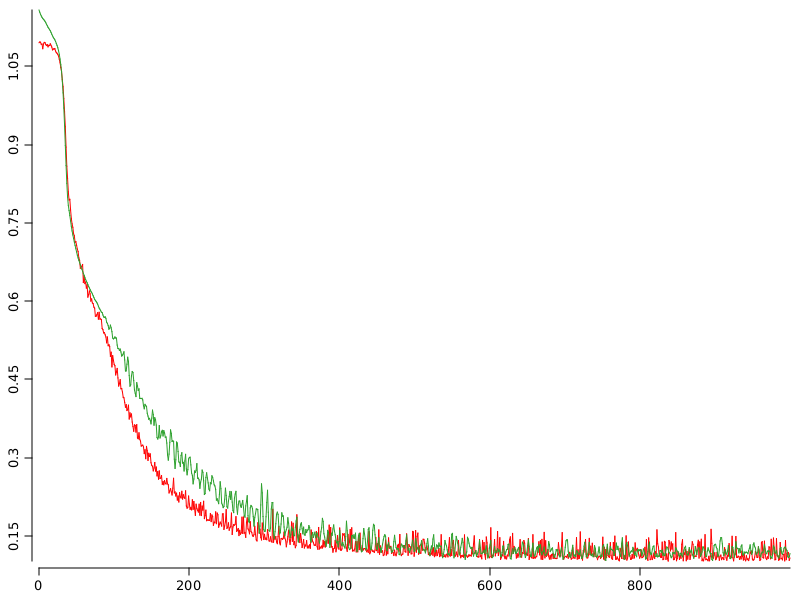

c1b53417-8578-4072-befa-554670d8c478

In [72]:
display(WS.image(lines(trainLoss, color(Color.RED), lwd(1)).lines(testLoss, color(2), lwd(1))));

As you can see, the pipeline for training is very similar with what you would expect in Pytorch. This is on purpose. Pytorch API is an inspiration (although we are talking about API only, I did not dig deep into inner workings). The reason why I think this kind of API is a good inspiration is because it is very logic and perhaps it arrived in that form after many years of experience. And I totally aggree.

Another thing which you can notice is that the model is very simple. Small layers with tiny number of parameters. This is because the problem is simple, and creating huge models with overparametrization does not help anybody. 

## Closing notes

While the functionality implemented for darrays is extensive, the tensor and neural network layers is not. This is because darrays benefited from many months of work, while the tensor couterpart did not. Still, all the required components are there and the frame was settled. This is a big milestone, to have all the compoenents in place and verified. Future revisions will enrich a lot the available components going probably towards convolutions, reccurent layers, embeddings and probably attention, transformers and what not.

Hope it was a fun journey and stay tuned.